In [1]:
from sqlalchemy import create_engine
from scipy import stats
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
from scipy.stats.mstats import winsorize
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

cars_df=pd.read_csv('/Users/steveangeli/Downloads/vehicles.csv')
cars_df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7034441763,https://saltlakecity.craigslist.org/cto/d/salt...,salt lake city,https://saltlakecity.craigslist.org,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,...,4wd,compact,hatchback,black,https://images.craigslist.org/00G0G_fTLDWM5Xyv...,PRICE REDUCED! -Garage kept -Low Miles (63K)...,NaN,ut,40.7372,-111.858
1,7034440610,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00v0v_7Cu0buIofU...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
2,7034440588,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,46463,2015.0,gmc,sierra 1500,excellent,NaN,...,4wd,NaN,NaN,white,https://images.craigslist.org/01515_lPvJ9bfbdY...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
3,7034440546,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00T0T_6Rjfp3NS4O...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
4,7034406932,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,49999,2018.0,ford,f-450,NaN,NaN,...,4wd,NaN,pickup,white,https://images.craigslist.org/00W0W_8yIUwRBXXd...,2018 Ford F-350 F350 F 350 SD Lariat Crew Cab ...,NaN,ut,40.3744,-104.694


In [2]:
# Drop some columns that I don't believe wil have much impact on the sale price or that have big problems.
cars_df.drop(columns=['url', 'model', 'region_url', 'vin', 'image_url', 'description', 'county', 'lat', 'long'], inplace=True)

# Drop any null rows because I still should have plenty of data to work with. 

cars_df.dropna(inplace=True)

# Dropping a couple of incorrect or unusual data entries.
mistakes_price = cars_df[cars_df['price'] > 100000].index
cars_df.drop(mistakes_price, inplace=True)

mistakes_price2 = cars_df[cars_df['price'] < 1000].index
cars_df.drop(mistakes_price2, inplace=True)

mistakes_year = cars_df[cars_df['year'] > 2019].index
cars_df.drop(mistakes_year, inplace=True)

mistakes_odom = cars_df[cars_df['odometer'] > 300000].index
cars_df.drop(mistakes_odom, inplace=True)

mistakes_odom2 = cars_df[cars_df['odometer'] < 5000].index
cars_df.drop(mistakes_odom2, inplace=True)

# Trimming down the years we're looking at to the past 15. 
cars_not_last_15 = cars_df[cars_df['year'] < 2004].index
cars_df.drop(cars_not_last_15, inplace=True)

cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81194 entries, 0 to 509564
Data columns (total 16 columns):
id              81194 non-null int64
region          81194 non-null object
price           81194 non-null int64
year            81194 non-null float64
manufacturer    81194 non-null object
condition       81194 non-null object
cylinders       81194 non-null object
fuel            81194 non-null object
odometer        81194 non-null float64
title_status    81194 non-null object
transmission    81194 non-null object
drive           81194 non-null object
size            81194 non-null object
type            81194 non-null object
paint_color     81194 non-null object
state           81194 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 10.5+ MB


In [3]:
# Set up our data:

car_features = cars_df[['year', 'manufacturer', 'odometer']]
car_features = pd.get_dummies(car_features)
car_features.head()

saleprice = cars_df.price

In [4]:
# # This is the model we'll be using.
# from sklearn.tree import DecisionTreeRegressor

# X = car_features
# Y = saleprice

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 13)

# # Fit regression model
# regr_1 = DecisionTreeRegressor(max_depth=2)
# regr_2 = DecisionTreeRegressor(max_depth=5)
# regr_1.fit(X_train, y_train)
# regr_2.fit(X_train, y_train)

# # Predictions
# y_preds1 = regr_1.predict(X_test)
# y_preds2 = regr_2.predict(X_test)

# plt.scatter(y_test, y_preds2)
# plt.plot(y_test, y_test, color="red")
# plt.xlabel("true values")
# plt.ylabel("predicted values")
# plt.title("True and predicted values")
# plt.show()

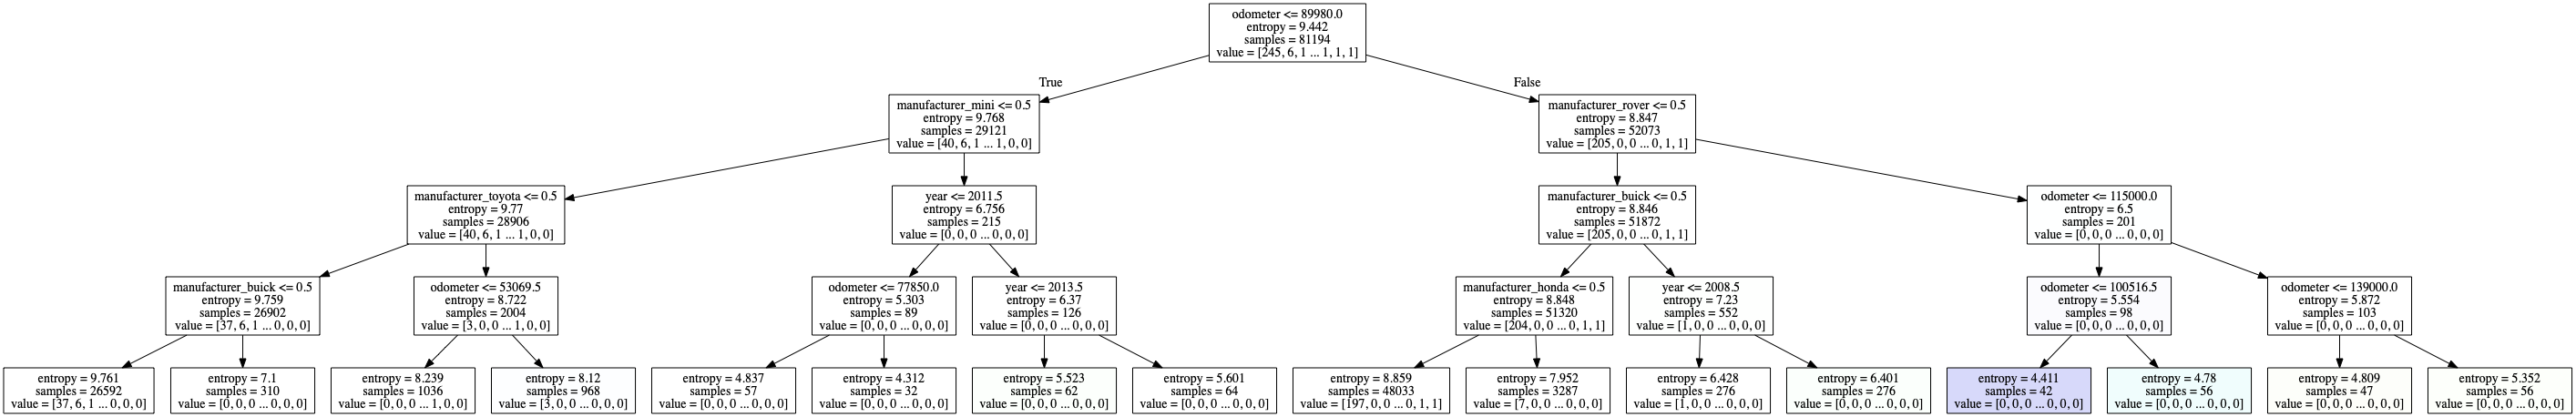

In [5]:
X = car_features
Y = saleprice

# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 13
)
decision_tree.fit(car_features, saleprice)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=car_features.columns,
#     class_names=['Not Returning', 'Returning'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [6]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

X = car_features
Y = saleprice

rfc = ensemble.RandomForestClassifier()

cross_val_score(rfc, X, Y, cv=10)

array([0.19206391, 0.28684407, 0.24393091, 0.223707  , 0.24272974,
       0.23479189, 0.25419566, 0.2302439 , 0.21287199, 0.15137482])